In [1]:
import matplotlib.pyplot as plt
from nltk.sentiment import vader
import numpy as np
import prep_financial_phrasebank as prep # library for preprocessing dataset
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



## Financial Phrasebank

This dataset contains labelled sentences extracted from financial news. 

Financial Phrasebank is a dataset downloaded from Hugging Face. It's split into 4 categories, each one based on the % of experts that agreed on the sentence's label:
1) sentences_50agree
2) sentences_66agree
3) sentences_75agree
4) sentences_100agree

The entire dataset contains 11,821 news articles. The library used to download the dataset, clean the data and create the labels is `prep_financial_phrasebank.py`



## Data preparation

Since our real data is in the form of news article abstracts, we perform certain data cleaning steps:

1) turn the entire sentence to lowercase
2) handle negations: The way we are handling negation is by using the wordnet library which contains lists of antonyms for several words. Whenever the word "not" or "n't" is encountered, we replace the next word with its antonym. For example, "not good" becomes "bad". This process will allow us to then remove stopwords without affecting the sentiment of the sentence.
3) remove punctuation
4) remove stopwords

After the cleaning is done, we proceed with sentence tokenization. For tokenization, we'll use two approaches:
1) single-embedding tokenization using the sentiment score for each word and **averaging** the sentiment scores for all words in a sentence
2) using pretrained word2vec embeddings. This approach uses pretrained embeddings generated from the google news 300 dataset which was trained on 100 billion words and generates vectors of 300 dimensions for each word. In this approach we try to extract as much context as possible from each word in the sentence.

### Single-embedding tokenization

We'll start with a simple model which gives each word a sentiment score. The sentence sentiment will be determined by the **average** of the sentiment scores of the words in the sentence.

For this model, we used the score method from the afinn library to get the sentiment scores for each word. 

We now trained three distinct models using these embeddings:
1) Logistic Regression
2) RNN
3) Gradient Boosting Classifier

Through our research, we came across the Gradient Boosting Classifier which is a tree-based ensemble model. We decided to try a prebuilt version of this model from sklearn ensemble library.

**Expectations**

Given that these embeddings don't take a sentence's context into account, we don't expect the RNN to perform well. However, we'll still train it to see how it performs.

In [2]:
afin = Afinn()

In [3]:
# import data
fp = prep.import_all_splits()
# clean data
fp = prep.tokenize_financial_phrasebank(fp)
# get X and y with afinn embeddings
X_single = prep.generate_X_vader(fp)
y_single = prep.generate_y_vader(fp)

In [15]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, test_size=0.2, random_state=42)

In [16]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_single, y_train_single)
print("afinn (train):", clf.score(X_train_single, y_train_single))
print("afinn (test):", clf.score(X_test_single, y_test_single))

afinn (train): 0.6023688663282571
afinn (test): 0.618064952638701


c:\Users\cerva\miniconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
gbc = prep.GradientBoost_experiment(X_train_single, y_train_single, X_test_single, y_test_single)
print("afinn (train):", gbc.score(X_train_single, y_train_single))
print("afinn (test):", gbc.score(X_test_single, y_test_single))

c:\Users\cerva\miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


afinn (train): 0.6023688663282571
afinn (test): 0.618064952638701


In [7]:
import torch
from torch import nn
from torch.optim import Adam

class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.from_numpy(X_train_single).float()
y_train_torch = torch.from_numpy(y_train_single).float()

# Reshape X_train to be (batch_size, sequence_length, input_size)
X_train_torch = X_train_torch.view(-1, 1, 1)

# Initialize the model, loss function, and optimizer
model = SimpleRNN(hidden_size=10)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    # print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [8]:
# Convert numpy arrays to PyTorch tensors
X_test_torch = torch.from_numpy(X_test_single).float()
y_test_torch = torch.from_numpy(y_test_single).float()

# Reshape X_test to be (batch_size, sequence_length, input_size)
X_test_torch = X_test_torch.view(-1, 1, 1)

# Switch model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_test_torch)

# Calculate the loss
loss = criterion(predictions, y_test_torch)
print(f'Test Loss: {loss.item()}')

# Convert the model's output to binary labels
predicted_labels = torch.round(predictions)

# Calculate the number of correct predictions
correct_predictions = (predicted_labels == y_test_torch).float().sum()

# Calculate the accuracy
accuracy = correct_predictions / y_test_torch.shape[0]

print(f'afinn accuracy: {accuracy.item()}')

Test Loss: 0.3628171384334564
afinn accuracy: 0.6180649399757385


As expected, we didn't observe major differences between the Logistic Regression model and the RNN. Interesting as well is that the Gradient Boosting Classifier didn't outperform either of the previous models.

### Semantic vector embeddings

The second approach we'll use is to use pretrained word2vec embeddings. In this approach we try to extract as much context as possible from each word in the sentence.

The cleaning process was the same as the single-embedding tokenization. 

**Expectations**

We would expect this approach to significantly outperform the single-embedding tokenization since it takes into account the context of each word in the sentence.

Additionally, since the RNN is trained sequentially, we would expect additional context to be captures by the RNN. For that reason we would expect to see the RNN show a significant improvement in performance over the Logistic Regression model. 

In [9]:
X_train, y_train, X_test, y_test = prep.aggregate_all_splits()


In [10]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
print("word2vec (train):", clf.score(X_train, y_train))
print("word2vec (test):", clf.score(X_test, y_test))

word2vec (train): 0.6467303950596396
word2vec (test): 0.6470389170896785


c:\Users\cerva\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
gbc = prep.GradientBoost_experiment(X_train, y_train, X_test, y_test)
print("word2vec (train):", gbc.score(X_train, y_train))
print("word2vec (test):", gbc.score(X_test, y_test))

word2vec (train): 0.8473056425006344
word2vec (test): 0.7912013536379019


In [12]:
prep.RNN_experiment_torch()

Finished Training
word2vec accuracy:  0.6514382402707276


As expected, each of the models improved on the results shown by the single-embedding tokenization. However, we were expecting the results to show a more significant improvement.

Contrary to our expectations, we didn't observe any significant improvement (sometimes even a decrease) in performance when using the RNN vs the Logistic Regression model.

What we find very interesting is that the Gradient Boosting Classifier significantly outperformed the other two models.

### Synthetic data generation

We generated synthetic data using the following process:
1) obtain a vocabulary of words using nltk's sentiment analyzer's lexicon
2) clean that vocabulary to only include words and filters out punctuation, numbers, etc.
3) generate random sized sentences using random words from the vocabulary
4) create a label for each sentence by taking the **average** of the sentiment scores of the words in the sentence. 

The following histogram shows the distribution of the sentiment score in each of the words in our vocabulary.

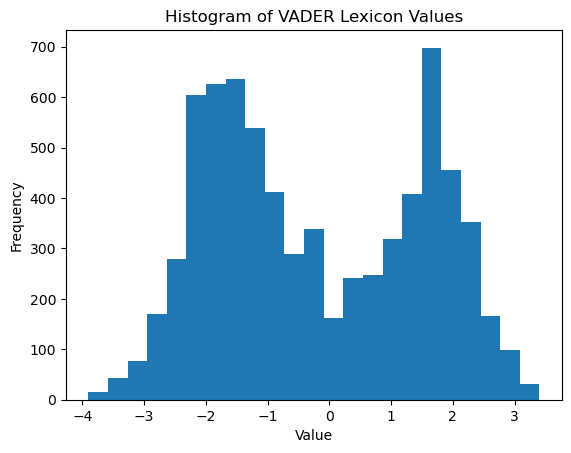

In [13]:
# Initialize VADER
sia = vader.SentimentIntensityAnalyzer()

# make a vocabulary from the lexicon which excludes non alpha tokens
vocab = sorted([token for token in sia.lexicon if token.isalpha()])

values = np.array([sia.lexicon[word] for word in vocab])

# show a histogram of vocab sentiment scores
plt.hist(values, bins='auto')  # 'auto' automatically determines the number of bins
plt.title('Histogram of VADER Lexicon Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Given the above distribution, we've decided to create a 'neutral' sentiment cutoff between [[ INPUT THE CUTOFFS WE CHOSE ]]. Aggregate scores below this range will be classified as 'negative' while scores above this range will be classified as 'positive'.